<a href="https://colab.research.google.com/github/peter-amerkhanian/computational-social-science-project6/blob/main/Project_5_Student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

As you're working, keep a few things in mind:
 

*   There are two independent Senators, Bernie Sanders (I-VT) and Angus King (I-ME), who both caucus with the Democratic Party.
*   There were three party switches in the House during the 116th Congress. Justin Amash (L-MI) switched from Republican to Independent to Libertarian, Paul Mitchell (I-MI) switched from Republican to Independent, and Je Van Drew (R-NJ) switched from Democratic to Republican.
*   There are some representatives who have a district number of "0". These states (Alaska, Delaware, Montana, North Dakota, South Dakota, Vermont, and Wyoming) have one "at-large" district that represents the whole
state in the House of Representatives.
*   There may be some inconsistencies that you  find throughout the dataset. For instance, Kamala Harris' twitter handle was "@SenKamalaHarris" but after her election as Vice President, her twitter handles are "@Kamala-Harris" and "@VP" so this was fixed. Wherever you find inconsistencies and are unsure how to resolve them, either create an issue on github or document the assumptions you make before proceeding with your analysis.

Overall, there are close to 1 million individual tweets in this corpus. Remember to start with smaller subsets of the data to make sure your code works before proceeding with a larger analysis! The dataset was constructed from a few different sources and required a substantial amount of preprocessing, so if there are any bugs or mistakes please do not hesitate to contact the instructors.

In [2]:
#obtain SRS of 10000 tweets to work with, given the dataset is so large 
#this could be moved to the end of preprocessing if we were able to run it on the entire sample
#code run locally to be able to work with the data

In [3]:
#code for mounting google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#need to drop the file into a public drive folder and link (something like /content/drive/MyDrive/Colab Notebooks/116th Congressional Tweets and Demographics.csv)
#df=pd.read_csv('/content/drive/MyDrive/CSS Project 5/116th Congressional Tweets and Demographics.csv')

In [5]:
! pip install scattertext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
# pandas and numpy
import pandas as pd
import numpy as np

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#extras
import re
!pip install tweet-preprocessor
import preprocessor as p
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
import scattertext as st
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
! pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from wordcloud import WordCloud

In [9]:
! pip install emoji
import emoji
emoji_list = list(emoji.EMOJI_DATA.keys())

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
#local data access (uncomment if running locally)
# Load data
#congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")

#access data on Github for when running in Colab (comment out if running locally)
# Load data, using SRS created above
congress_tweets = pd.read_csv("https://raw.githubusercontent.com/peter-amerkhanian/css_project_5/main/116th_Congress_Sample.csv",
                                               low_memory=False)


# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
#congress_tweets.head()

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

In [11]:
congress_tweets.head()

,Unnamed: 0,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688"
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744"
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447"
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958"


In [12]:
#cleaning for link, mentions, and hashtags--remove them from text data

def remove_links(text):
    """Takes a string and removes web links from it"""
    text = re.sub(r'http\S+', '', text)   # remove http links
    text = re.sub(r'bit.ly/\S+', '', text)  # remove bitly links
    text = text.strip('[link]')   # remove [links]
    text = re.sub(r'pic.twitter\S+','', text)
    return text

def remove_users(text):
    """Takes a string and removes retweet and @user information"""
    text = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove re-tweet
    text = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove tweeted at
    return text

def remove_hashtags(text):
    """Takes a string and removes any hash tags"""
    text = re.sub('(#[A-Za-z]+[A-Za-z0-9-_]+)', '', text)  # remove hash tags
    return text

def remove_av(text):
    """Takes a string and removes AUDIO/VIDEO tags or labels"""
    text = re.sub('VIDEO:', '', text)  # remove 'VIDEO:' from start of tweet
    text = re.sub('AUDIO:', '', text)  # remove 'AUDIO:' from start of tweet
    return text

In [13]:
#clean emoji from dataset
def strip_emoji(text):
    RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    return RE_EMOJI.sub(r'', text)

In [14]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)

    punc |= {"“", "”", "'", "\n"}
    
    punc_free = "".join([ch for ch in text if ch not in punc])
    
    doc = nlp(punc_free)
    
    # spacy_words = [token.text for token in doc]
    
    spacy_words = [token.text.lower() for token in doc if token.text.lower() != 'amp']

    spacy_words = [word for word in spacy_words if not word.startswith('http')]
   
    no_punc = [word for word in spacy_words if word not in stop_words]

    shortword = re.compile(r'\W*\b\w{1,2}\b')

    no_short_words = [word for word in no_punc if not bool(shortword.match(word))]

    no_emojis = [word for word in no_short_words if word not in emoji_list]
    
    return no_emojis

In [15]:
test = congress_tweets['text'][1000:1100].map(lambda x: rem_punc_stop(x))
" ".join(test.apply(lambda x: " ".join(x)))

'speakerpelosi – science tells – focus expanding testing contact tracing way safely reopen economy amr familiesfirst senator correct time livestock producers stand lose branding war like america dairies realmeatact kearneyhub editorial litigated highprofile constitutional law cases federal courts ears coming congressand seen prosecutors case completely destroyed opening defense argument realdonaldtrumps team today days eviscerated hrs boom wealth talent creativity community tell stories ourstories matter ourvoices deserve heard chcdiversity chctohollywood hispaniccaucus uscannenberg issue runs deep film industry hierarchy entrylevel talent csuite executives cameramen assistants latinos left left nearly recruit promote latino talent workers gopleader chairman adam schiff repeatedly denied fundamental fairness process course sham impeachmentrt agree stop blocking important witnesses testifying honest history   native american history american history celebrate incredible contributions na

In [16]:
#tokenize
#could use the specific package for tokenizing tweets, but using this for consistency with lab approach
congress_tweets['tokens'] = congress_tweets['text'].map(lambda x: rem_punc_stop(x))
congress_tweets['tokens']
congress_tweets['tokens_wv'] = congress_tweets['tokens']

We considered but decided against several preprocessing steps (e.g. stemming and lemmetization) in the first pass of working with these data. 

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1

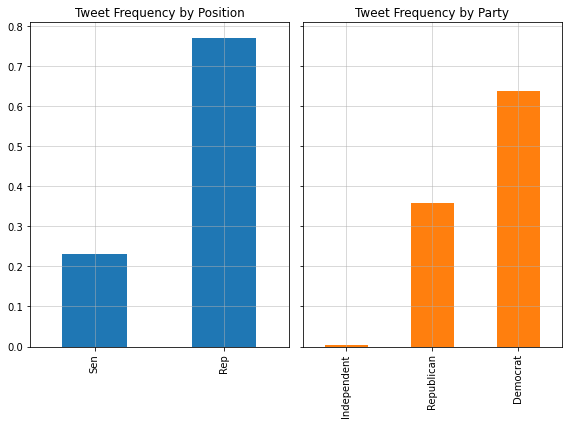

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6), sharey=True)
#frequency of outcomes in sample, by position
congress_tweets['position'].value_counts(normalize=True).sort_values().plot(kind="bar", ax=ax[0], color="tab:blue")
#frequency of outcomes in sample, by party
congress_tweets['party'].value_counts(normalize=True).sort_values().plot(kind="bar", ax=ax[1], color="tab:orange")
ax[0].grid(alpha=.6)
ax[1].grid(alpha=.6)
ax[0].set_title("Tweet Frequency by Position")
ax[1].set_title("Tweet Frequency by Party")
fig.tight_layout()

### EDA 2

In [18]:
all_text = " ".join(congress_tweets['tokens'].apply(lambda x: " ".join(x)))

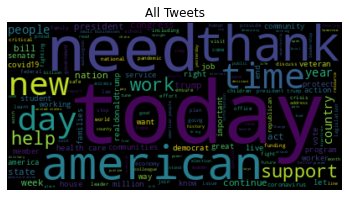

In [19]:
#word cloud overall
wordcloud = WordCloud().generate(all_text)
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("All Tweets")
plt.axis('off')
plt.show()

In [20]:
#word cloud by senator vs. representative
sen_tweets = congress_tweets[congress_tweets['position'] == 'Sen']
rep_tweets = congress_tweets[congress_tweets['position'] == 'Rep']
all_text_sen = " ".join(sen_tweets['tokens'].apply(lambda x: " ".join(x)))
all_text_rep = " ".join(rep_tweets['tokens'].apply(lambda x: " ".join(x)))

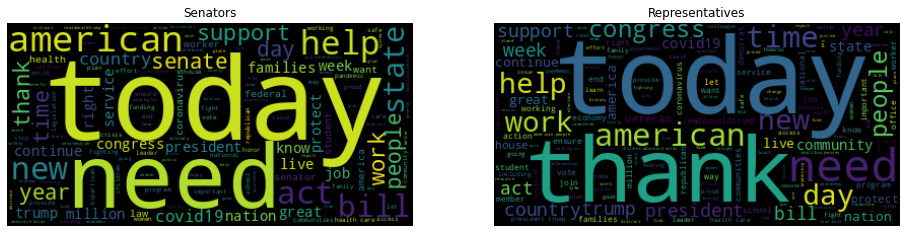

In [21]:
wordcloud_sen = WordCloud().generate(all_text_sen)
wordcloud_rep = WordCloud().generate(all_text_rep)

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(wordcloud_sen, interpolation = 'bilinear')
ax[0].set_title("Senators")
ax[0].axis('off')
ax[1].imshow(wordcloud_rep, interpolation = 'bilinear')
ax[1].set_title("Representatives")
ax[1].axis('off');

In [22]:
#word cloud by dem vs. rep
dem_tweets = congress_tweets[congress_tweets['party'] == 'Democrat']
rep_tweets = congress_tweets[congress_tweets['party'] == 'Republican']
all_text_dem = " ".join(dem_tweets['tokens'].apply(lambda x: " ".join(x)))
all_text_rep = " ".join(rep_tweets['tokens'].apply(lambda x: " ".join(x)))

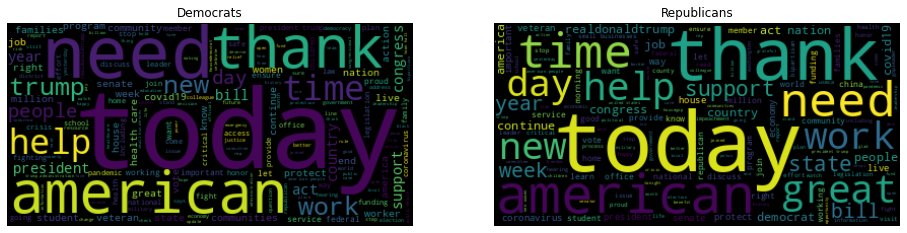

In [23]:
wordcloud_dem = WordCloud().generate(all_text_dem)
wordcloud_rep = WordCloud().generate(all_text_rep)

fig, ax = plt.subplots(1, 2, figsize=(16, 16))
ax[0].imshow(wordcloud_dem, interpolation = 'bilinear')
ax[0].set_title("Democrats")
ax[0].axis('off')
ax[1].imshow(wordcloud_rep, interpolation = 'bilinear')
ax[1].set_title("Republicans")
ax[1].axis('off');

## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [24]:
#sentiment polarity for whole dataset
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
congress_tweets['polarity'] = congress_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
congress_tweets.head()

,Unnamed: 0,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,tokens_wv,polarity
0,217331,1.174780e+18,RepValDemings,2019-09-19T16:10:19-04:00,Thank you for testifying today Mr. Blake. http...,Val Demings,Rep,3-Jan-17,3/12/1957,F,FL,10,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",thank testifying today blake jrblake repvaldem...,"[thank, testifying, today, blake, jrblake, rep...",0.000000
1,258764,1.139590e+18,RepHankJohnson,2019-06-14T14:05:48-04:00,My Twitter Town Hall on healthcare has begun a...,Hank Johnson,Rep,3-Jan-07,10/2/1954,M,GA,4,Democrat,"2,089,104","1,877,963","1,773,827","2,078,688",twitter town hall healthcare begun answering q...,"[twitter, town, hall, healthcare, begun, answe...",0.136364
2,50091,1.217600e+18,RepFrenchHill,2020-01-15T19:02:21-05:00,Scipio Jones‘ fight for civil rights and equal...,French Hill,Rep,3-Jan-15,12/5/1956,M,AR,2,Republican,"684,872","380,494","394,409","647,744",scipio jones ‘ fight civil rights equality imp...,"[scipio, jones, ‘, fight, civil, rights, equal...",0.511111
3,205601,1.120440e+18,RepTedDeutch,2019-04-22T17:49:57-04:00,There is no better time to #ActOnClimate than ...,Ted Deutch,Rep,13-Apr-10,5/7/1966,M,FL,22,Democrat,"4,617,886","4,504,975","4,237,756","4,163,447",better time actonclimate earthday role play pr...,"[better, time, actonclimate, earthday, role, p...",0.450000
4,85993,1.167160e+18,RepLaMalfa,2019-08-29T15:43:43-04:00,I understand the VA often has problems recruit...,Doug LaMalfa,Rep,3-Jan-13,7/2/1960,M,CA,1,Republican,"4,483,814","8,753,792","7,854,285","4,839,958",understand problems recruiting qualified physi...,"[understand, problems, recruiting, qualified, ...",0.000000


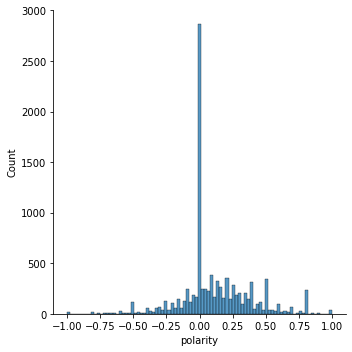

In [25]:
#Density plot of sentiment polarity
sns.displot(congress_tweets, x="polarity")
plt.show()

###Skewing positive, many cluster at 0 (or just below 0)

In [26]:
for tweet in congress_tweets.nlargest(5, 'polarity')['tokens']:
    print(tweet + "\n")

    ### checking example re: polarity and data cleaning

austintxyrs awesome day campaigning travisgop leadright

threat wildfires increases communities greatest risk equitable access firefighting emergency equipment federal programs dod transfers excess property forest service provides states use firefighting

help survivors breast cancer return health achieve best quality life introducing breast cancer patient equity act lisamurkowski repjudychu repwalorski

unemployment fell 638 jobs added market oct america economy recovering leadership realdonaldtrump fought nation day continue best come

vindmans ’ story america story kenburns remember vindman boys fondly theirs story america best



In [27]:
sample_tweet = "RT AustinTXYRs Awesome day campaigning TravisGOP LeadRight As threat wildfires increases communities greatest risk equitable access firefighting emergency equipment Under federal programs DoD transfers excess property US Forest Service provides states use firefighting We help survivors breast cancer return health achieve best quality life That s I m introducing Breast Cancer Patient Equity Act lisamurkowski RepJudyChu amp RepWalorski Unemployment fell 69 638 K jobs added market Oct America economy recovering leadership realDonaldTrump He fought nation DAY ONE amp continue THE BEST IS YET TO COME The Vindmans ’ story America story QT KenBurns I remember Vindman boys fondly Theirs story America best"
print("overall polarity score is ", TextBlob(sample_tweet).sentiment.polarity)
for word in sample_tweet.split():
    print(word, TextBlob(word).sentiment.polarity)

##Words contributing to polarity score of 1.0: Awesome, greatest, best, BEST, best -- seems overall on the right track

overall polarity score is  1.0
RT 0.0
AustinTXYRs 0.0
Awesome 1.0
day 0.0
campaigning 0.0
TravisGOP 0.0
LeadRight 0.0
As 0.0
threat 0.0
wildfires 0.0
increases 0.0
communities 0.0
greatest 1.0
risk 0.0
equitable 0.0
access 0.0
firefighting 0.0
emergency 0.0
equipment 0.0
Under 0.0
federal 0.0
programs 0.0
DoD 0.0
transfers 0.0
excess 0.0
property 0.0
US 0.0
Forest 0.0
Service 0.0
provides 0.0
states 0.0
use 0.0
firefighting 0.0
We 0.0
help 0.0
survivors 0.0
breast 0.0
cancer 0.0
return 0.0
health 0.0
achieve 0.0
best 1.0
quality 0.0
life 0.0
That 0.0
s 0.0
I 0.0
m 0.0
introducing 0.0
Breast 0.0
Cancer 0.0
Patient 0.0
Equity 0.0
Act 0.0
lisamurkowski 0.0
RepJudyChu 0.0
amp 0.0
RepWalorski 0.0
Unemployment 0.0
fell 0.0
69 0.0
638 0.0
K 0.0
jobs 0.0
added 0.0
market 0.0
Oct 0.0
America 0.0
economy 0.0
recovering 0.0
leadership 0.0
realDonaldTrump 0.0
He 0.0
fought 0.0
nation 0.0
DAY 0.0
ONE 0.0
amp 0.0
continue 0.0
THE 0.0
BEST 1.0
IS 0.0
YET 0.0
TO 0.0
COME 0.0
The 0.0
Vindmans 0.0
’ 0.0

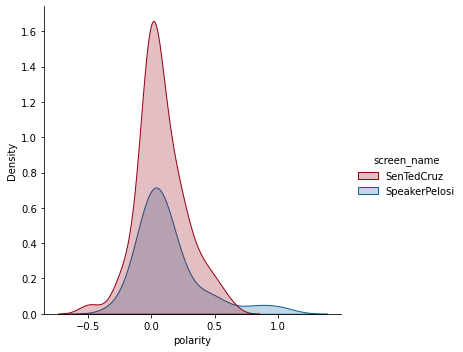

In [28]:
#choose two legislators
#Nancy Pelosi and Ted Cruz

#starting code
#sns.displot(congresstweets, x="polarity", hue = "Product", col = "Product")
#plt.show()

#Choosing relevant party colors
colors = ["#930014", "#0b6099"]

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

pelosi_cruz = congress_tweets[(congress_tweets['screen_name'] == 'SpeakerPelosi') | (congress_tweets['screen_name'] == 'SenTedCruz')]
sns.displot(pelosi_cruz, x="polarity", hue="screen_name", kind="kde", fill=True);

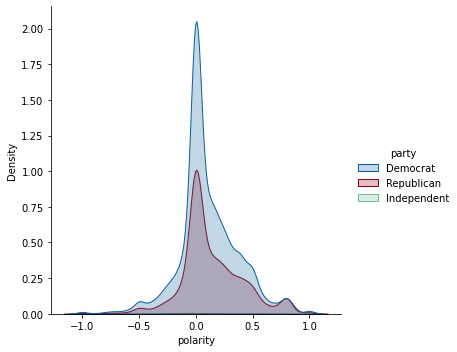

In [29]:
#visualization to compare polarity among all Democrats v. Republicans 
#Choosing relevant party colors
colors = ["#0b6099", "#930014", "#6fb98f"]

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.displot(congress_tweets, x="polarity", hue="party", kind="kde", fill=True);

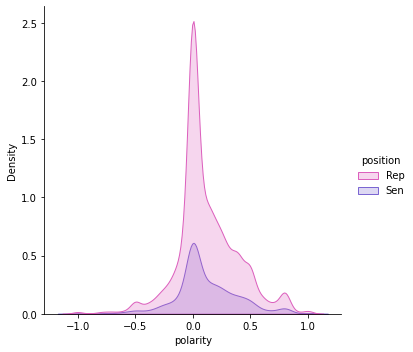

In [30]:
#visualization to compare polarity among Senators v. Representatives
colors = ["#dc5fbd", "#7b66d2"]

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

sns.displot(congress_tweets, x="polarity", hue="position", kind="kde", fill=True);

In [31]:
#add step to create new df for sentiment results

Sentiment scores are not discriminant, so we are choosing not to proceed with this as a featurization technique.

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.


### Tf-idf

In [32]:
# Frequency Based featurization
X = congress_tweets['tokens']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

#create dataframe for tf-idf matrix
# tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())

/usr/local/lib/python3.9/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [33]:
tf.get_feature_names_out()

array([' ', '  ', '   ', ..., '🏿\u200d', '🧍↔️🧍\u200d', '🧍🏻\u200d'],
      dtype=object)

In [34]:
tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names_out())

### Topic modeling: LDA (Engineered text features)

In [35]:
from sklearn.decomposition import LatentDirichletAllocation

In [36]:
# LDA topic modeling
lda = LatentDirichletAllocation(n_components=5, max_iter=20, random_state=0)
lda = lda.fit(tfidf_matrix)

In [37]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [38]:
tf_feature_names = tf.get_feature_names_out()
print_top_words(lda, tf_feature_names, 15)


Topic #0:
richard countyofla wilderness del article comparison lcvoters los arizonans que stoneman cruz rivers congrats flying

Topic #1:
today    covid19 help health thank great need work new support community coronavirus state care

Topic #2:
que los para del corrupt información cnn con más por las releasethereport ¡ sobre sus

Topic #3:
celebrating para hanukkah christmas weekly por happy wishing festival hardball update thejusticedept accomplishments join que

Topic #4:
president trump today    house people act american vote senate time — americans bill congress



In [39]:
lda_df = pd.DataFrame(lda.components_, columns=tf.get_feature_names_out())

In [40]:
lda_df.index = [f"Topic_{i}" for i in range(5)]

In [41]:
lda_df

,,,,,,,,,,,...,🏽‍,🏾httpshaalandhousegovmediapressreleaseshaalandvotesyesnextstepsimpeachmentinquiry,🏾rootedinoakland,🏾‍,🏾‍🦽,🏿cbc2020summit,🏿redfored,🏿‍,🧍↔️🧍‍,🧍🏻‍
Topic_0,0.208973,0.213246,0.200713,0.201673,0.450825,0.200063,0.200044,0.200039,0.200054,0.200044,...,0.209068,0.200148,0.200053,0.417058,0.427854,0.200040,0.200066,0.200048,0.200047,0.427854
Topic_1,19.766361,76.349294,4.290112,2.081268,0.250598,0.200022,0.200016,0.200011,0.200014,0.200015,...,1.118595,0.722477,0.200016,0.202647,0.201620,0.200011,0.207020,0.663236,0.383288,0.201620
Topic_2,0.505617,0.350746,0.201779,0.422495,0.200185,0.200063,0.200044,0.200038,0.200053,0.200042,...,0.201211,0.200147,0.200053,0.200071,0.200024,0.200039,0.200065,0.208954,0.200047,0.200024
Topic_3,0.201393,0.838158,0.201182,0.245742,0.200187,0.277307,0.432702,0.200039,0.200054,0.200046,...,0.200045,0.200148,0.200054,0.758750,0.200026,0.200040,0.200065,0.200046,0.200047,0.200026
Topic_4,8.112819,51.667030,3.445632,0.751360,0.200067,0.200191,0.200133,0.747388,0.566054,0.405504,...,0.200018,0.211315,0.478857,0.200026,0.200009,0.476501,0.395061,0.200017,0.200019,0.200009


**Note:** lda_df[i, j] can be viewed as pseudocount that represents the number of times word j was assigned to topic i. It can also be viewed as distribution over the words for each topic after normalization

In [42]:
topic_mat = lda.transform(tfidf_matrix)

In [43]:
topics_df = pd.DataFrame(topic_mat, columns=[f"Topic_{i}" for i in range(5)])

In [44]:
topics_df = topics_df.drop(columns=['Topic_0'])

In [45]:
topics_df

,Topic_1,Topic_2,Topic_3,Topic_4
0,0.708451,0.168342,0.040361,0.042399
1,0.803896,0.048885,0.048864,0.049497
2,0.037664,0.036302,0.036295,0.853444
3,0.805979,0.047202,0.047620,0.051997
4,0.826066,0.043252,0.043174,0.043795
...,...,...,...,...
9995,0.037991,0.036668,0.036679,0.851995
9996,0.814608,0.046137,0.045905,0.047445
9997,0.815377,0.046011,0.046010,0.046592
9998,0.046945,0.045655,0.045615,0.816171


**Note:** lda_df[i, j] can be viewed as the probability that document i is of topic j

### Word Embedding

In [46]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.Word2Vec(congress_tweets['tokens_wv'], vector_size=1000, window=3, 
                               min_count=1, sg=0, alpha=0.025, epochs = 5, batch_words=10000)
doc = [word for word in congress_tweets['tokens_wv'][0] if word in model.wv.index_to_key]


In [47]:
doc
#words = list(model.wv.index_to_key)
#words

['thank',
 'testifying',
 'today',
 'blake',
 'jrblake',
 'repvaldemings',
 'gave',
 'impassioned',
 'speech',
 'place',
 'experience',
 'having',
 'served',
 'years',
 'police',
 'force',
 ' ',
 'thank']

In [48]:
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
#def document_vector(word2vec_model, doc):
#    doc = [word for word in doc if word in model.vocab]
#    return np.mean(model[doc], axis=0)

def document_vector(word2vec_model, doc):
    if len(doc) == 0:
      return np.zeros(1000)
    doc = [word for word in doc if word in model.wv.index_to_key]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0)

  

In [49]:
# embedding based featurization
empty_list_embeddings_means = []
# for idx, puppy in enumerate(congress_tweets['tokens_wv']):
#   if len(puppy) == 0:
#     del congress_tweets['tokens_wv'][idx]

for puppy in congress_tweets['tokens_wv']: # append the vector for each document
  empty_list_embeddings_means.append(document_vector(model, puppy))


In [50]:
doc_average_embeddings = np.array(empty_list_embeddings_means, dtype=object)
doc_average_embeddings.shape

(10000, 1000)

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

In [51]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])
#LASSO as our chosen model

In [52]:
congress_tweets['position'].value_counts()

Rep    7701
Sen    2299
Name: position, dtype: int64

In [53]:
congress_tweets[congress_tweets['party'] == 'Independent']['name_wikipedia'].value_counts()

Bernie Sanders    25
Angus King         8
Name: name_wikipedia, dtype: int64

In [54]:
congress_tweets['party'].value_counts()

Democrat       6384
Republican     3583
Independent      33
Name: party, dtype: int64

In [55]:
congress_tweets['party'] = congress_tweets['party'].replace({'Independent': 'Democrat'})

In [56]:
# Set y 
y = congress_tweets['party']

# X (tf_idf feature)
X = tfidf_df

X_columns = tfidf_df.columns

# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_df, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20)

# X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
#                                                     train_size=0.75, test_size=0.25)


Adding a step to oversample, given the class imbalance in our data

In [57]:
!pip install imbalanced-learn
from imblearn.under_sampling import RandomUnderSampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
random_under_sampler = RandomUnderSampler(replacement=True)
X_train_tf_new, y_train_tf_new = random_under_sampler.fit_resample(X_train_tf, y_train_tf)

In [59]:
from sklearn.metrics import accuracy_score
def metrics(cf_matrix, number):
  accuracy  = np.trace(cf_matrix) / float(np.sum(cf_matrix))
  print(f"Model {number} accuracy is", accuracy)
  precision = cf_matrix[1,1] / sum(cf_matrix[:,1])
  print(f"Model {number} precision is", precision)
  recall = cf_matrix[1,1] / sum(cf_matrix[1,:])
  print(f"Model {number} recall is", recall)
  f1_score  = 2*precision*recall / (precision + recall)
  print(f"Model {number} F1 score is", f1_score)

**Model 1: Tf-IDF, democrat/republican**

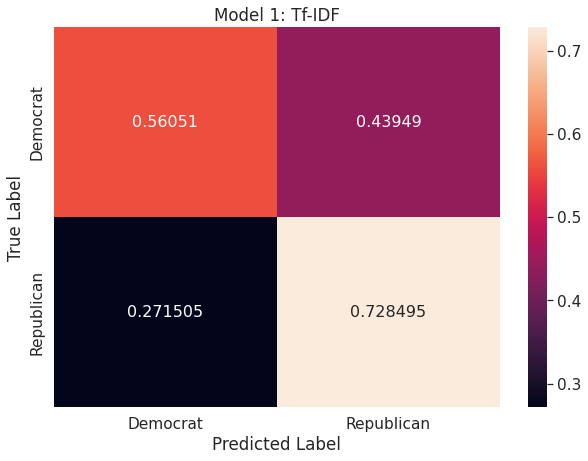

In [ ]:
#Model 1: Tf-IDF, democrat/republican
# create a model 
lasso_reg = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)

# fit the model
lasso_model = lasso_reg.fit(X_train_tf_new, y_train_tf_new)

y_pred = lasso_model.predict(X_test_tf)

cf_matrix = confusion_matrix(y_test_tf, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title('Model 1: Tf-IDF')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Model 1 Performance**

In [ ]:
metrics(cf_matrix, 1)

Model 1 performance:



*   Accuracy is 0.64450
*   Precision is 0.62372
*   Recall is 0.72849
*   F1 score is 0.67204



**Model 2: Tf-IDF, senator/representative**

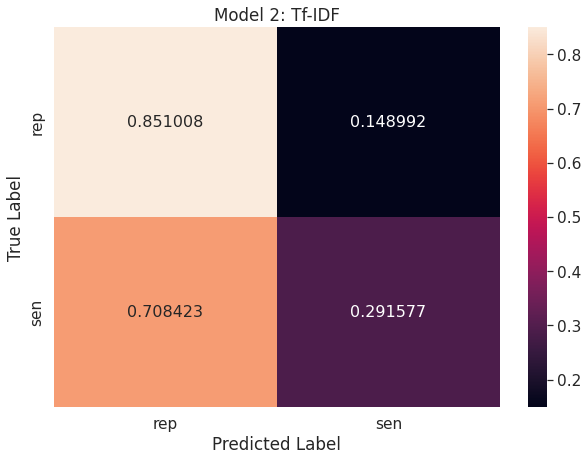

In [62]:
#Model 2: Tf-IDF, senator/representative
# # Set y 
y = congress_tweets['position']

# # X (tf_idf feature)
X = tfidf_df

X_columns = tfidf_df.columns


# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(tfidf_df, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20)

X_train_tf_new, y_train_tf_new = random_under_sampler.fit_resample(X_train_tf, y_train_tf)
# create a model 
lasso_reg = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)

# fit the model
lasso_model = lasso_reg.fit(X_train_tf_new, y_train_tf_new)
y_pred = lasso_model.predict(X_test_tf)
    
cf_matrix = confusion_matrix(y_test_tf, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "rep", 1: "sen"})
df_cm.index = ["rep", "sen"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title('Model 2: Tf-IDF')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Model 2 Performance**

In [63]:
metrics(cf_matrix, 2)

Model 2 accuracy is 0.5712925659506121
Model 2 precision is 0.6618195852284688
Model 2 recall is 0.2915766738660907
Model 2 F1 score is 0.40480786770365007


Model 2 performance: 

*   Accuracy is 0.51262
*   Precision is 0.81905
*   Recall is 0.032397
*   F1 score is 0.0623294



**Model 3: LDA, democrat/republican**

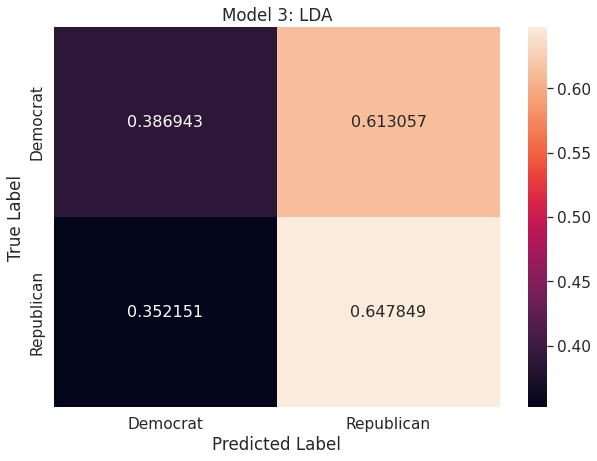

In [64]:
#Model 3: LDA, democrat/republican
# Set y 
y = congress_tweets['party']

# X (everything except diabetes, our target, and also non-float variables)
X = topics_df

X_columns = topics_df.columns

# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_tf_new, y_train_tf_new = random_under_sampler.fit_resample(X_train_tf, y_train_tf)

# create a model 
lasso_reg = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
# fit the model
lasso_model = lasso_reg.fit(X_train_tf_new, y_train_tf_new)

y_pred = lasso_model.predict(X_test_tf)
    
cf_matrix = confusion_matrix(y_test_tf, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title('Model 3: LDA')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [65]:
metrics(cf_matrix, 3)

Model 3 accuracy is 0.5173960687624135
Model 3 precision is 0.5137964748377285
Model 3 recall is 0.6478494623655914
Model 3 F1 score is 0.5730881662450965


**Model 4: LDA, senator/representative**

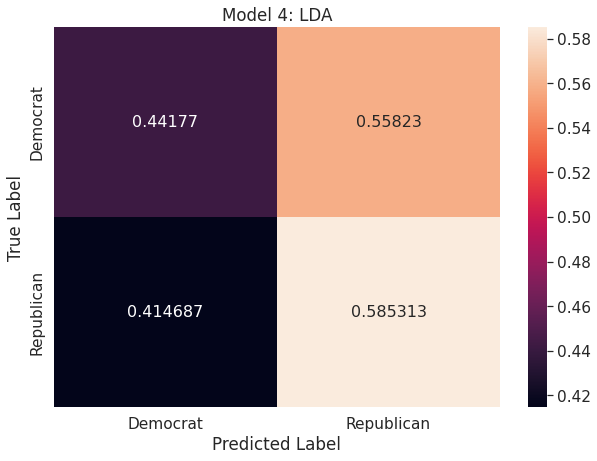

In [66]:
#Model 4: LDA, senator/representative
y = congress_tweets['position']

# X (everything except diabetes, our target, and also non-float variables)
X = topics_df

X_columns = topics_df.columns

# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_tf_new, y_train_tf_new = random_under_sampler.fit_resample(X_train_tf, y_train_tf)

# create a model 
lasso_reg = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
# fit the model
lasso_model = lasso_reg.fit(X_train_tf_new, y_train_tf_new)

y_pred = lasso_model.predict(X_test_tf)
    
cf_matrix = confusion_matrix(y_test_tf, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

df_cm = df_cm.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
            annot=True,
            annot_kws={"size": 16},
            fmt='g')

plt.title('Model 4: LDA')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [67]:
metrics(cf_matrix, 4)

Model 4 accuracy is 0.5135414280715708
Model 4 precision is 0.5118416379836837
Model 4 recall is 0.5853131749460043
Model 4 F1 score is 0.5461173768136085


**Model 5: Word Embeddings, republican/democrat**

In [68]:
#Model 5: Word Embeddings, republican/democrat
# Set y 
y_wv = congress_tweets['party']

# X 
X_wv = doc_average_embeddings

X_wv = pd.DataFrame(X_wv)

X_wv_columns = X_wv.columns

# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_wv, X_test_wv, y_train_wv, y_test_wv = train_test_split(X_wv, 
                                                    y_wv, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_wv_new, y_train_wv_new = random_under_sampler.fit_resample(X_train_wv, y_train_wv)


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


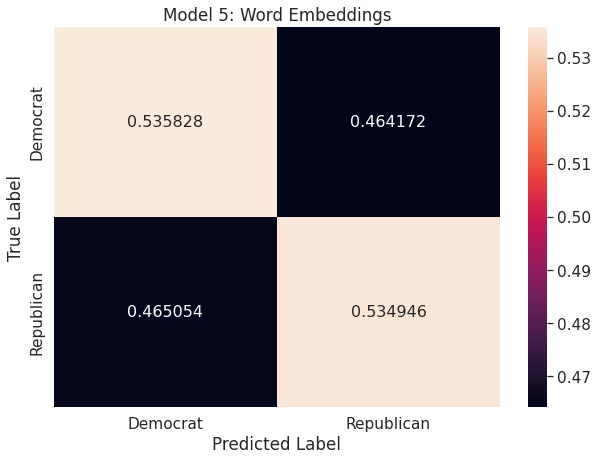

In [69]:
lasso_reg_wv = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)

# fit the model
lasso_model_wv = lasso_reg_wv.fit(X_train_wv_new, y_train_wv_new)

y_pred_wv = lasso_model_wv.predict(X_test_wv)

cf_matrix_wv = confusion_matrix(y_test_wv, y_pred_wv, normalize = "true")

df_cm_wv = pd.DataFrame(cf_matrix_wv, range(2),
                  range(2))

df_cm_wv = df_cm_wv.rename(index=str, columns={0: "Democrat", 1: "Republican"})
df_cm_wv.index = ["Democrat", "Republican"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_wv, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Model 5: Word Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
metrics(cf_matrix_wv, 5)

In [ ]:
#Model 6: Word2vec, senator/representative
# Set y 
y_wvpos = congress_tweets['position']

# X 
X_wvpos = doc_average_embeddings

X_wvpos = pd.DataFrame(X_wvpos)

X_wvpos_columns = X_wvpos.columns

# set the random seed
np.random.seed(10)

# split the data for tf-idf position model
X_train_wvpos, X_test_wvpos, y_train_wvpos, y_test_wvpos = train_test_split(X_wvpos, 
                                                    y_wvpos, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_wvpos_new, y_train_wvpos_new = random_under_sampler.fit_resample(X_train_wvpos, y_train_wvpos)


In [ ]:
lasso_reg_wvpos = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)

# fit the model
lasso_model_wvpos = lasso_reg_wv.fit(X_train_wvpos_new, y_train_wvpos_new)

y_pred_wvpos = lasso_model_wvpos.predict(X_test_wvpos)

cf_matrix_wvpos = confusion_matrix(y_test_wvpos, y_pred_wvpos, normalize = "true")

df_cm_wvpos = pd.DataFrame(cf_matrix_wvpos, range(2),
                  range(2))

df_cm_wvpos = df_cm_wvpos.rename(index=str, columns={0: "rep", 1: "sen"})
df_cm_wvpos.index = ["rep", "sen"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm_wvpos, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Model 6: Word Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
metrics(cf_matrix_wvpos, 6)

### Two Combined Models

In [74]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])
X_numeric = pd.concat([congress_tweets.iloc[:, 13:16], congress_tweets.iloc[:, -1]], axis=1).replace(',','', regex=True).astype(float)
y_rep = congress_tweets['position']
y_party = congress_tweets['party']

In [ ]:
# rep
X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(X_numeric, 
                                                    y_rep, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_rep_new, y_train_rep_new = random_under_sampler.fit_resample(X_train_rep, y_train_rep)
# party
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(X_numeric, 
                                                    y_party, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_party_new, y_train_party_new = random_under_sampler.fit_resample(X_train_party, y_train_party)

**Predicting position with only numerical features**

In [ ]:
lasso_reg_rep = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
lasso_reg_rep.fit(X_train_rep_new, y_train_rep_new)
y_pred = lasso_reg_rep.predict(X_test_rep)
cf_matrix_rep = confusion_matrix(y_test_rep, y_pred, normalize = "true")
metrics(cf_matrix_rep, 7)
print("confusion matrix")
cf_matrix_rep

**Predicting party with only numerical features**

In [78]:
lasso_reg_party = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
lasso_reg_party.fit(X_train_party_new, y_train_party_new)
y_pred = lasso_reg_party.predict(X_test_party)
cf_matrix_party = confusion_matrix(y_test_party, y_pred, normalize = "true")
metrics(cf_matrix_party, 8)
print("confusion matrix")
cf_matrix_party

Model 8 accuracy is 0.7920335429769392
Model 8 precision is 0.7643263757115749
Model 8 recall is 0.8444444444444444
Model 8 F1 score is 0.8023904382470118
confusion matrix


array([[0.73962264, 0.26037736],
       [0.15555556, 0.84444444]])

In [79]:
del doc_average_embeddings, topics_df

In [80]:
df_tfidf_numbers = pd.concat([X_numeric, tfidf_df], axis=1)

In [81]:
del X_numeric, tfidf_df

In [82]:
# rep
X_train_rep, X_test_rep, y_train_rep, y_test_rep = train_test_split(df_tfidf_numbers, 
                                                    y_rep, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_rep_new, y_train_rep_new = random_under_sampler.fit_resample(X_train_rep, y_train_rep)

del X_train_rep, y_train_rep
# party
X_train_party, X_test_party, y_train_party, y_test_party = train_test_split(df_tfidf_numbers, 
                                                    y_party, 
                                                    train_size = .80, 
                                                    test_size=0.20)
X_train_party_new, y_train_party_new = random_under_sampler.fit_resample(X_train_party, y_train_party)
del X_train_party, y_train_party

**Predicting position with numerical and text features**

In [83]:
lasso_reg_rep = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
lasso_reg_rep.fit(X_train_rep_new, y_train_rep_new)
y_pred = lasso_reg_rep.predict(X_test_rep)
cf_matrix_rep = confusion_matrix(y_test_rep, y_pred, normalize = "true")
metrics(cf_matrix_rep, 9)
print("confusion matrix")
cf_matrix_rep

Model 9 accuracy is 0.553527097090166
Model 9 precision is 0.7197379367720466
Model 9 recall is 0.17532467532467533
Model 9 F1 score is 0.2819642299387536
confusion matrix


array([[0.93172952, 0.06827048],
       [0.82467532, 0.17532468]])

In [84]:
del lasso_reg_rep

**Predicting party with numerical and text features**

In [85]:
lasso_reg_party = LogisticRegression(penalty='l1', C=.5, solver='saga', tol=1e-3)
lasso_reg_party.fit(X_train_party_new, y_train_party_new)
y_pred = lasso_reg_party.predict(X_test_party)
cf_matrix_party = confusion_matrix(y_test_party, y_pred, normalize = "true")
metrics(cf_matrix_party, 10)
print("confusion matrix")
cf_matrix_party

Model 8 accuracy is 0.7839556720165957
Model 8 precision is 0.758213282235085
Model 8 recall is 0.8338028169014085
Model 8 F1 score is 0.7942135395271201
confusion matrix


array([[0.73410853, 0.26589147],
       [0.16619718, 0.83380282]])

## Discussion Questions

**1. Why do standard preprocessing techniques need to be further customized to a particular corpus?**

Standard preprocessing technique are by definition standard, meaning that they are intended to address what are seen as 'standard' aspects of preprocessing to clean and prepare data for analyses. This often looks like removing punctuation, removing stopwords, lower-casing, and stemming or lemmetization. But when you're dealing with a particular corpus of data and seeking to address a specific research question or set of questions, those preprocessing approaches should be tailored to the tasks at hand. 

Each text data corpus is generated in a way that shapes its contents and therefore how it should be preprocessed. This is particularly apparent when working with a corpus of data like tweets, as the structure of Twitter and common practices for use of the platform mean that there are different cleaning considerations than there might be for a corpus of text like the text of political speeches. Specifically, we know that tweets commonly have links, hastags, emoji, and likely common abbreviations and slang that would not be seen in formally written prose or transcribed text. As such, the preprocessing approach for tweets seeks to minimize the noise created by these unique considerations in the corpus of text, to elevate the meaningful information that can be gained to address the classification questions for this project. 

**2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?**

There was little evidence that Democrats and Republicans or Senators and Representatives had different sentiments in their tweets. However, it is important to note that data was skewed such that there were far more Democrats and far more Representatives in the sample dataset. In both cases, the distribution of sentiment had a very similar pattern. Notably, in comparing a single Republican with a large representation of tweets (Ted Cruz) and a Democrat with less tweets (Nancy Pelosi), there was still little differnce between their sentiment. A slight difference was present in that Ted Cruz had a lower minimum sentiment value, e.g. had more negative tweets, and Nancy Pelosi had a higher maximum sentiment value, e.g. more positive tweets, although this margin looks insignificant and the majority of their tweets followed a similar sentiment distribution.

It may be that sentiment across certain topics may provide better discrimination of these two outcomes, e.g. Republicans and Democrats might talk the same general amount about taxes, but one may use more negative language and the other may be more positive. Averaging sentiment across Topics constructed by LDA may create a more predictive set of sentiment related text featyres.

**3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?**

Exploratory analyses and unsupervised learning approaches are integral parts of an analysis process. Exploratory data analyses providing key information about what the data look like (What information does it contain? Are the are concerns with it that should be accounted for prior to analysis such as class imbalance or further cleaning steps that should be taken? Etc.) and allow us to both describe the data at hand generally and develop an informed approach to working with the data to answer our research question(s), but exploratory analyses do not carry out classification tasks. Unsupervised learning approaches allow for the detection of 'hidden' patterns in the data, inductively generating insights into what's happening in the data without human intervention in that process. Unsupervised learning is a powerful tool to work with unlabaled data for tasks like clustering, association, and even preparation of data for supervised learning tasks but presents a notable risk of inaccurate results. Accordingly, the validation of  an unsupervised method with a supervised learning approach generally improves the accuracy of results while also allowing for different tasks such as classification and regression. 

While in this instance, we have labeled data so a supervised approach is relatively easy to execute for classification, this type of validation would be much more time intensive or even impossible in a situation where data were not labeled, which might a situation where a semi-supervised approach is appropriate. 

**4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?**

```
Model 9 accuracy is 0.553527097090166
Model 9 precision is 0.7197379367720466
Model 9 recall is 0.17532467532467533
Model 9 F1 score is 0.2819642299387536
confusion matrix
array([[0.93172952, 0.06827048],
       [0.82467532, 0.17532468]])
```